# Importing Necessary Libraries:
For our project, we made heavy use of the sklearn library. We stored all of the necessary imports in this first section.

In [1]:
import pandas as pd
import numpy as np
import time
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits
from sklearn.cluster import *
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import homogeneity_score, homogeneity_completeness_v_measure
from sklearn.preprocessing import scale
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

# Verifying Integrity of Numerical Columns, and The Conversion of Non-Numerical Columns:
Before any analysis or clustering was done with our data, and before any questions were asked we needed to verify that our data was clean and ready to use. We thought this was the case during the first milestone, but ran into a few problems.

The location of schools should needed to be considered when doing any type of analysis. In order to incorporate the location of these schools into our methods, we converted the State and City columns to numerical values. These values have no weight, but identify the locations in point-space to examine them during clustering. For example, a state like Utah may be converted to a value like 13, where all other occurances of Utah would also be converted to 13. The same process was applied for cities.

Another issue we ran into during our clustering was that the data had not been sufficiently cleaned. We ran into two major issues. The first being the existence of a non-varying feature which would break scaling algorithms due to 0 variance. The second issue we faced was there were quite a few private schools with NaN information, as they were not collected or reported to the government when gathering the data. 

To resolve these problems we did the following:
1. We removed any columns that had no variance as these columns made very little difference to any analysis.
2. We imputed any NaN values with the feature's median value to avoid any outliers, but also to allow us to process the data for most of the schools. We had considered dropping these schools, but we would have lost about half of the dataset. Most of these schools had a majority of their information, but only a few NaN features.

We also checked for any features that were non-numeric, which was not an issue as the data had been cleaned before.

In [2]:
school_data = pd.read_csv('data_files/BASE_clean_college_score_card_data.csv', index_col=0)
school_data_original = pd.read_csv('data_files/BASE_clean_college_score_card_data.csv', index_col=0)

# Changing categorical data values to numerical. Here we are mapping states to digits 0-58 (As they
# include more than just the 50 typical states, like BC and Puerto Rico)

# The same is being done for the cities, where they will mapped from 0-2k
state_index_list = []
for i, state in enumerate(set(school_data['STABBR'])):
    state_index = (state, i)
    state_index_list.append(state_index)
    
state_dictionary = dict(state_index_list)
state_dictionary

city_index_list = []
for i, city in enumerate(set(school_data['CITY'])):
    city_index = (city, i)
    city_index_list.append(city_index)
    
city_dictionary = dict(city_index_list)
city_dictionary

school_data.replace({'CITY': city_dictionary, 'STABBR': state_dictionary}, inplace=True)

# Removing the name of the school, as we will not be considering this during clustering.
numeric_school_data = school_data.iloc[:,1:]

#------------------------------------------------------------------------------
# This next section will impute the data, and verify the integrity of the data.
#------------------------------------------------------------------------------

# Resolving any NaN values using Imputation
# Credit to O.rka at https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera
# For this short process.
fill_NaN = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_DF = pd.DataFrame(fill_NaN.fit_transform(numeric_school_data))
imputed_DF.columns = numeric_school_data.columns
imputed_DF.index = numeric_school_data.index


def verify_data(dataframe):
    '''Check the validity of the data, and verifies it is ready for processing
       variables:
       dataframe - The dataframe of the data looking to be processed.
    '''
    # Check for incorrect column types
    for i in range(len(dataframe.dtypes)):
        if dataframe.dtypes[i] != dataframe.dtypes[1]:
            print(dataframe.dtypes[i])

    print("No other bad dtypes.")

    # Check for NaN values
    if dataframe.isnull().values.any() == True:
        print(np.where(np.isnan(dataframe)))
    
    print("No other NaN values.")

    # Checking each value for infinite values
    for i in range(len(dataframe.columns)):
        for j in range(len(dataframe.index)):
            if np.isfinite(dataframe.iloc[j,i]) == False:
                print(j,i)
                print(dataframe.iloc[j,i])

    print("No other non-finite values.")
    
    # Checking each feature for 0 variance
    for col in dataframe.columns:
        if len(dataframe[col].unique()) == 1:
            print("WARNING:", col, "has only 1 unique value (0 variance) and may cause issues when scaling")
    print("No other 0 variance columns found.")
    
verify_data(imputed_DF)
print("\n")
# Not sure why curroper remained in our data after it was removed, removing it again.
imputed_DF = imputed_DF.drop(columns=['CURROPER'])
verify_data(imputed_DF)

scaled_imputed_df = pd.DataFrame(scale(imputed_DF))
scaled_imputed_df.columns = imputed_DF.columns

# Looking at the new scaled imputed dataframe
scaled_imputed_df.head()
        

No other bad dtypes.
No other NaN values.
No other non-finite values.
No other 0 variance columns found.


No other bad dtypes.
No other NaN values.
No other non-finite values.
No other 0 variance columns found.


,CITY,STABBR,HCM2,PREDDEG,HIGHDEG,CONTROL,LOCALE,HBCU,PBI,ANNHI,...,PCTFLOAN,UG25ABV,MD_EARN_WNE_P10,GT_25K_P6,GT_28K_P6,GRAD_DEBT_MDN_SUPP,GRAD_DEBT_MDN10YR_SUPP,RPY_3YR_RT_SUPP,C150_L4_POOLED_SUPP,C150_4_POOLED_SUPP
0,0.721873,-1.466816,-0.098265,1.081687,1.299137,-1.313341,-0.850394,8.078207,-0.120002,-0.062453,...,1.040007,-1.363837,-0.272113,-0.439433,-0.296063,2.288798,2.288798,-1.230989,0.152473,-1.678625
1,-1.288957,-1.466816,-0.098265,1.081687,1.299137,-1.313341,-0.850394,-0.123790,-0.120002,-0.062453,...,0.103860,-0.671960,0.466201,0.923957,0.926331,0.816178,0.816178,0.366588,0.152473,0.426362
2,1.661301,-1.466816,-0.098265,1.081687,1.299137,-0.120011,-0.850394,-0.123790,-0.120002,-0.062453,...,1.329355,2.183870,0.350387,0.854525,0.382365,0.958759,0.958759,-1.368116,0.152473,-0.019170
3,-0.759642,-1.466816,-0.098265,1.081687,1.299137,-1.313341,-0.850394,-0.123790,-0.120002,-0.062453,...,-0.222362,-0.721643,0.864312,1.024949,1.036346,0.925981,0.925981,0.578199,0.152473,0.018313
4,1.661301,-1.466816,-0.098265,1.081687,1.299137,-1.313341,-0.850394,8.078207,-0.120002,-0.062453,...,1.207821,-1.310934,-0.510979,-0.818153,-0.785021,2.120183,2.120183,-1.442740,0.152473,-2.051747


# The Benefits of Going to College.

Our initial question for this project was the benefit of tuition. We had three main things we wanted to analyze. 
1. Is tuition worth it? Does paying more in tuition increase the income you will expect to receive?
2. What schools are most cost effective?
3. What can we learn with clustering?

We begin with our first question.

## 1. Is Tuition Worth It?
In highschool, it is often the case that they will show the earnings after receiving varying levels of education. This includes the expected earnings with only a high-school diploma, an associates degree, a bachelors degree, and so on. We wanted to see specifically, how much more can you make relative to how much you <b>spend</b>? This question is not often asked amongst students, rather the question focuses on which degree you study, and where you study. To expand on the latter, we divide these into three categories of school along with an example of each.
1. Public Schools (University of Utah)
2. Private Non-Profit Schools (Brigham Young University)
3. Private For-Profit Schools (Eagle Gate College)

We created a scatterplot of the data to look for any interesting characteristics.

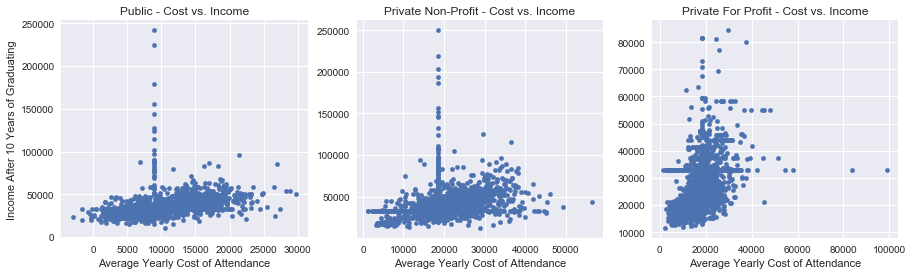

In [3]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

public_schools = imputed_DF[imputed_DF['CONTROL'] == 1]            # 0
private_np_schools = imputed_DF[imputed_DF['CONTROL'] == 2]        # 1
private_fp_schools = imputed_DF[imputed_DF['CONTROL'] == 3]        # 2

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2]);

ax[0].title.set_text('Public - Cost vs. Income')
ax[0].set_xlabel('Average Yearly Cost of Attendance')
ax[0].set_ylabel('Income After 10 Years of Graduating')

ax[1].title.set_text('Private Non-Profit - Cost vs. Income')
ax[1].set_xlabel('Average Yearly Cost of Attendance')
ax[1].set_ylabel('')

ax[2].title.set_text('Private For Profit - Cost vs. Income')
ax[2].set_xlabel('Average Yearly Cost of Attendance')
ax[2].set_ylabel('')

plt.show()

We can see something strange happens for a specific price point, namely around 10,000 and 20,000 (for public, and private non-profit respectively). We will revist these groups later. For now, let us examine the general case for schools, and look for centroids to see  what to expect when paying for school, and what to expect for potential earnings.

In [4]:
# Removing outliers for general analysis
public_schools     = imputed_DF[(imputed_DF['CONTROL'] == 1) & (imputed_DF['MD_EARN_WNE_P10'] < 100000)] # 0
private_np_schools = imputed_DF[(imputed_DF['CONTROL'] == 2) & (imputed_DF['MD_EARN_WNE_P10'] < 100000)] # 1
private_fp_schools = imputed_DF[(imputed_DF['CONTROL'] == 3) & 
                                (imputed_DF['MD_EARN_WNE_P10'] < 100000) &
                                (imputed_DF['NPT4_PRIV'] < 60000)] # 2

# Finding centroids:
x_pub = list(public_schools['MD_EARN_WNE_P10'])
y_pub = list(public_schools['NPT4_PUB'])
centroid_pub = (sum(x_pub) / len(list(public_schools['MD_EARN_WNE_P10'])), 
                sum(y_pub) / len(list(public_schools['NPT4_PUB'])))

x_priv_np = list(private_np_schools['MD_EARN_WNE_P10'])
y_priv_np = list(private_np_schools['NPT4_PRIV'])
centroid_priv_np = (sum(x_priv_np) / len(list(private_np_schools['MD_EARN_WNE_P10'])), 
                    sum(y_priv_np) / len(list(private_np_schools['NPT4_PUB'])))

x_priv_fp = list(private_fp_schools['MD_EARN_WNE_P10'])
y_priv_fp = list(private_fp_schools['NPT4_PRIV'])
centroid_priv_fp = (sum(x_priv_fp) / len(list(private_fp_schools['MD_EARN_WNE_P10'])), 
                    sum(y_priv_fp) / len(list(private_fp_schools['NPT4_PUB'])))

print(centroid_pub, centroid_priv_np, centroid_priv_fp)

(35204.85770363101, 9765.474484789009) (39998.11023622047, 20367.303937007873) (29538.925680647535, 17446.67476085357)


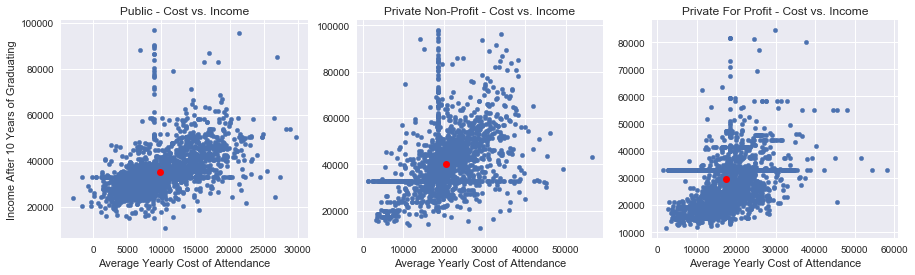

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2]);

# plt.point.plot(x=centroid_pub[1], y=centroid_pub[0], ax=ax[0], style='bx', label='point')
ax[0].plot(centroid_pub[1], centroid_pub[0], 'ro') 
ax[0].title.set_text('Public - Cost vs. Income')
ax[0].set_xlabel('Average Yearly Cost of Attendance')
ax[0].set_ylabel('Income After 10 Years of Graduating')

ax[1].plot(centroid_priv_np[1], centroid_priv_np[0], 'ro') 
ax[1].title.set_text('Private Non-Profit - Cost vs. Income')
ax[1].set_xlabel('Average Yearly Cost of Attendance')
ax[1].set_ylabel('')

ax[2].plot(centroid_priv_fp[1], centroid_priv_fp[0], 'ro') 
ax[2].title.set_text('Private For Profit - Cost vs. Income')
ax[2].set_xlabel('Average Yearly Cost of Attendance')
ax[2].set_ylabel('')

plt.show()

Here we can see expected for example, that the expected cost of going to a public school is \\$9765.47 per year, and the expected income is \\$35204.86 10 years after graduation.

We created a few regression models to see how much tuition affected the potential earnings after graduation in general.

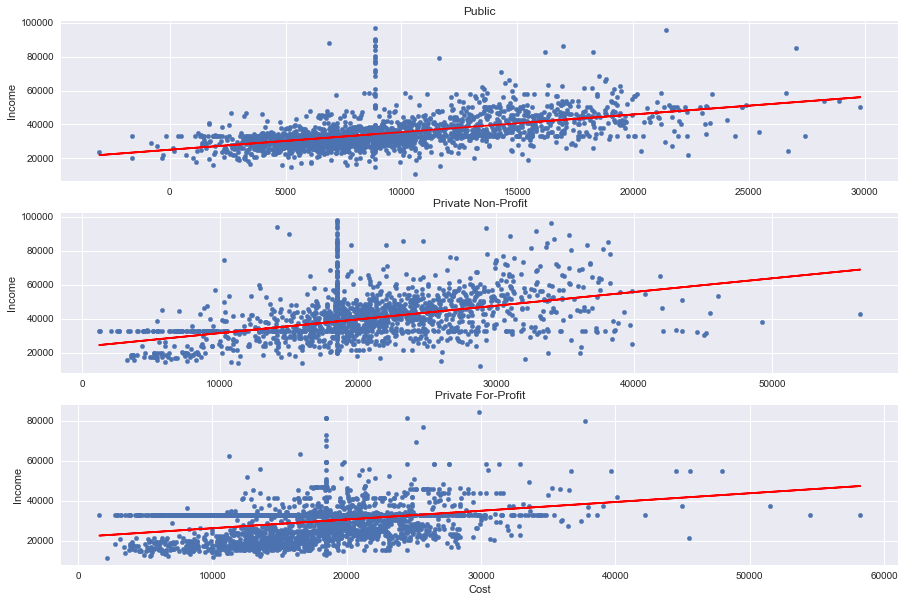

In [6]:
# Public School Regression Model
public_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PUB", 
                     data=public_schools).fit()
pub_predictions = public_ols.predict()

# Private Non-Profit School Regression Model
private_np_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PRIV", 
                     data=private_np_schools).fit()
priv_np_prections = private_np_ols.predict()

# Private Non-Profit School Regression Model
private_fp_ols = smf.ols(formula="MD_EARN_WNE_P10 ~ NPT4_PRIV", 
                     data=private_fp_schools).fit()
priv_fp_prections = private_fp_ols.predict()

# Graphing
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(15,10)) 

public_schools.plot.scatter(x='NPT4_PUB', y='MD_EARN_WNE_P10', ax=ax[0])
ax[0].plot(public_schools['NPT4_PUB'], pub_predictions, color='red')
ax[0].set_title("Public")
ax[0].set_xlabel('')
ax[0].set_ylabel('Income')

private_np_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[1])
ax[1].set_title("Private Non-Profit")
ax[1].plot(private_np_schools['NPT4_PRIV'], priv_np_prections, color='red')
ax[1].set_xlabel('')
ax[1].set_ylabel('Income')

private_fp_schools.plot.scatter(x='NPT4_PRIV', y='MD_EARN_WNE_P10', ax=ax[2])
ax[2].set_title("Private For-Profit")
ax[2].plot(private_fp_schools['NPT4_PRIV'], priv_fp_prections, color='red')
ax[2].set_xlabel('Cost')
ax[2].set_ylabel('Income');

These models do in fact show somewhat of a positive correlation with tuition. While the data varies heavily, it does seem to indicate that, especially with public schools, the more you pay in tuition, the more you will make after school. These effects are much less pronounced in private schools, and vary wildly. This may be caused by the different restrictions that public schools must adhere to, especially when reporting as a Title IV insitution (schools that process <b>federal</b> financial aid).

With these models we can see how much of the variance is explained by looking at the $R^2$ value, and see what the coeffecients are for these functions. This may give us an idea how much more (per dollar spent) you could make in income after 10 years.

In [7]:
print("Overview for each regression model:\n===================================")

print("Public Schools:\n-----------------------------------")
print("R Squared Value:", public_ols.rsquared)
print("With function paramters:\n", public_ols.params, sep="")

print("\n")

print("Private Non-Profit Schools:\n-----------------------------------")
print("R Squared Value:", private_np_ols.rsquared)
print("With function paramters:\n", private_np_ols.params, sep="")

print("\n")

print("Private For-Profit Schools:\n-----------------------------------")
print("R Squared Value:", private_fp_ols.rsquared)
print("With function paramters:\n", private_fp_ols.params, sep="")


Overview for each regression model:
Public Schools:
-----------------------------------
R Squared Value: 0.2641026853576184
With function paramters:
Intercept    25035.512356
NPT4_PUB         1.041357
dtype: float64


Private Non-Profit Schools:
-----------------------------------
R Squared Value: 0.18838413380296004
With function paramters:
Intercept    23623.048604
NPT4_PRIV        0.803988
dtype: float64


Private For-Profit Schools:
-----------------------------------
R Squared Value: 0.09340134417341595
With function paramters:
Intercept    21895.468406
NPT4_PRIV        0.438104
dtype: float64


Revisiting the outliers. We suspsect that this strange spike in those values is due to imputation of the data, let us examine more closely to verify this.

In [8]:
print(imputed_DF[(imputed_DF['CONTROL'] == 1) & 
     (imputed_DF['MD_EARN_WNE_P10'] > 100000)][['NPT4_PUB','MD_EARN_WNE_P10']])

print()

outliers = school_data[(imputed_DF['CONTROL'] == 1) & 
                               (imputed_DF['MD_EARN_WNE_P10'] > 100000)]['INSTNM']

school_data_outliers = school_data
school_data_outliers = school_data_outliers.set_index('INSTNM').reindex()
school_data_outliers.loc[outliers, ['NPT4_PUB', 'MD_EARN_WNE_P10']]

      NPT4_PUB  MD_EARN_WNE_P10
215     8860.0         114700.0
239     8860.0         143700.0
1595    8860.0         179000.0
2461    8860.0         127900.0
2878    8860.0         241900.0
3582    8860.0         102100.0
3596    8860.0         155100.0
3686    8860.0         124600.0
3859    8860.0         224300.0



,NPT4_PUB,MD_EARN_WNE_P10
INSTNM,,
University of California-Hastings College of Law,NaN,114700.0
University of California-San Francisco,NaN,143700.0
University of Massachusetts Medical School Worcester,NaN,179000.0
SUNY Downstate Medical Center,NaN,127900.0
Oklahoma State University Center for Health Sciences,NaN,241900.0
University of Texas Southwestern Medical Center,NaN,102100.0
University of North Texas Health Science Center,NaN,155100.0
Eastern Virginia Medical School,NaN,124600.0
West Virginia School of Osteopathic Medicine,NaN,224300.0


It appears that the assumption was correct. The data may not have been reported as these schools most likely have separate medical schools within them that report differently, or they are private schools that chose not to. The specific reason as to why these schools did not report there yearly costs is unknown. Unfortunately we can't rely on all of the imputed data, but for clustering purposes this should not cause too much of a skew.

## 2. What Schools Are Most Cost Effective?
We can also do a basic analysis of the percentage change in yearly cost and yearly salary. This only uses one year for each, as scalars should not affect this calculation. For this we are going to use the formula $$\frac{S - T}{T}\cdot 100$$
where $S$ is the salary 10 years after graduation (for one year) and $T$ is the cost of attendance (for one year). This is just a general ranking of these schools, but can provide some insight as to which schools should be looked at first when looking for which school to attend.

As an example, let us compare the University of Utah to BYU. This will give us the following:

In [9]:
uofu = school_data[school_data['INSTNM'] == "University of Utah"][['NPT4_PUB', 'MD_EARN_WNE_P10']].values
t_1 = uofu[0][0]
s_1 = uofu[0][1]
print(t_1, s_1)
print((s_1 - t_1) / (t_1))

byu = school_data[school_data['INSTNM'] == "Brigham Young University-Provo"][['NPT4_PRIV', 'MD_EARN_WNE_P10']].values
t_2 = byu[0][0]
s_2 = byu[0][1]
print(t_2, s_2)
print((s_2 - t_2) / (t_2))


12674.0 53000.0
3.1817894902950923
12795.0 59700.0
3.6658851113716295


In this case BYU would "outrank" UofU because the cost of tuition is less, but you are expected to make more. We will now create a new dataframe with this information to take a quick look. We will also be removing any schools that do not report their information instead of imputing them, as it makes no sense for this situation.

In [10]:
def rank_schools(df):
    '''Ranks schools based off of the formula above'''
    warnings.filterwarnings('ignore')
    
    # Break schools into public and private, and remove any schools with no info
    public_df  = df[df['NPT4_PUB'].notnull() & df['MD_EARN_WNE_P10'].notnull()]
    private_df = df[df['NPT4_PRIV'].notnull() & df['MD_EARN_WNE_P10'].notnull()]
    
    # 
    ratio_list = []
    for i in range(len(public_df)):
        t_1 = public_df.iloc[i, public_df.columns.get_loc('NPT4_PUB')]
        s_1 = public_df.iloc[i, public_df.columns.get_loc('MD_EARN_WNE_P10')]
        ratio_list.append((s_1 - t_1) / (t_1))
        
    public_df['COST_EFC'] = ratio_list
    
    # Reset ratio list, and do the same for private schools
    ratio_list = []
    for i in range(len(private_df)):
        t_1 = private_df.iloc[i, private_df.columns.get_loc('NPT4_PRIV')]
        s_1 = private_df.iloc[i, private_df.columns.get_loc('MD_EARN_WNE_P10')]
        ratio_list.append((s_1 - t_1) / (t_1))
        
    private_df['COST_EFC'] = ratio_list
    
    # Combining and sorting the list by COST_EFC
    combined_df = pd.concat([public_df, private_df])
    combined_df = combined_df.sort_values(by=['COST_EFC'], ascending=False)
    combined_df = combined_df.reset_index()
    warnings.filterwarnings('default')
    return combined_df

In [11]:
ranked_schools = rank_schools(school_data_original)
ranked_schools.head()[['STABBR', 'INSTNM', 'NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10', 'COST_EFC']]

,STABBR,INSTNM,NPT4_PUB,NPT4_PRIV,MD_EARN_WNE_P10,COST_EFC
0,UT,Ogden-Weber Technical College,139.0,NaN,26000.0,186.050360
1,NC,Cleveland Community College,168.0,NaN,24500.0,144.833333
2,GA,Albany Technical College,702.0,NaN,21700.0,29.911681
3,OK,Gordon Cooper Technology Center,1227.0,NaN,34900.0,27.443358
4,CA,Grossmont College,1353.0,NaN,34000.0,24.129342


We can see that the most cost effective school does not necessarily mean the best school to go to, as some of the salary does not warrant four to six years of attending the school. What about the schools where the salary is good?

In [12]:
ranked_schools[ranked_schools['MD_EARN_WNE_P10'] > 50000].head(10)[['INSTNM', 'NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10', 'COST_EFC']]

,INSTNM,NPT4_PUB,NPT4_PRIV,MD_EARN_WNE_P10,COST_EFC
34,United States Merchant Marine Academy,6866.0,NaN,88100.0,11.831343
106,CUNY Bernard M Baruch College,7193.0,NaN,57200.0,6.952176
137,Princeton University,NaN,10256.0,74700.0,6.283541
160,University of Connecticut-Stamford,8383.0,NaN,58400.0,5.966480
176,Georgia Institute of Technology-Main Campus,11639.0,NaN,79100.0,5.796117
177,University of Connecticut-Waterbury Campus,8600.0,NaN,58400.0,5.790698
194,Stanford University,NaN,14155.0,94000.0,5.640763
207,University of Washington-Tacoma Campus,8829.0,NaN,57700.0,5.535281
261,Harvard University,NaN,14981.0,89700.0,4.987584
266,Baptist Memorial College of Health Sciences,NaN,9592.0,57000.0,4.942452


These results are more of what is expected. Now that we have a general idea of what schools are cost effective, how does each state compare?

In [13]:
ranked_schools_sorted = ranked_schools.sort_values(by=['COST_EFC']).groupby(['STABBR']).mean()

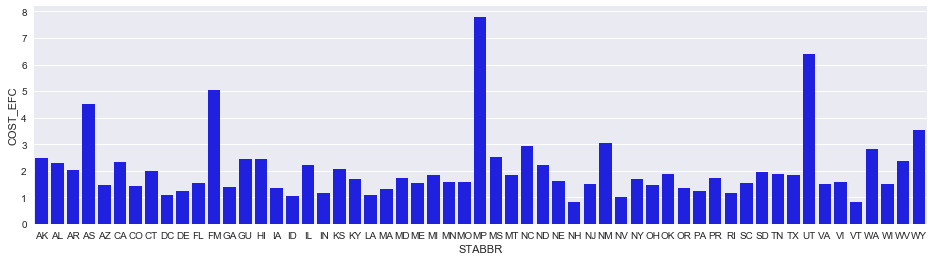

In [14]:
plt.rcParams['figure.figsize'] = (16, 4)
sns.barplot(x=ranked_schools_sorted.index, y="COST_EFC", data=ranked_schools_sorted, color="blue");

We can see now that America Somoa, Micronesia, Northern Mariana Islands, and Utah are the most cost effective states. Let us see the highest return for each of these states.

In [15]:
interesting_cols = ['INSTNM', 'CITY', 'STABBR', 'COST_EFC', 'NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10', 'COST_EFC']
mask = ((ranked_schools['STABBR'] == 'AS') | (ranked_schools['STABBR'] == 'FM') 
                                           | (ranked_schools['STABBR'] == 'MP')
                                           | (ranked_schools['STABBR'] == 'UT'))
high_efc_states = ranked_schools[mask][interesting_cols]

However, these most cost effective states have extremely low salaries after graduation, if we reduce our list to schools that average over \\$35,000 we can see that the most cost effective place to go to school is Utah.

In [16]:
high_efc_states = ranked_schools[mask][interesting_cols]
high_efc_states[high_efc_states['MD_EARN_WNE_P10'] > 35000]

,INSTNM,CITY,STABBR,COST_EFC,NPT4_PUB,NPT4_PRIV,MD_EARN_WNE_P10,COST_EFC
359,Utah Valley University,Orem,UT,4.342115,8199.0,NaN,43800.0,4.342115
533,Brigham Young University-Provo,Provo,UT,3.665885,NaN,12795.0,59700.0,3.665885
571,LDS Business College,Salt Lake City,UT,3.536290,NaN,7936.0,36000.0,3.536290
617,Weber State University,Ogden,UT,3.423899,10059.0,NaN,44500.0,3.423899
644,Salt Lake Community College,Salt Lake City,UT,3.326812,8690.0,NaN,37600.0,3.326812
719,University of Utah,Salt Lake City,UT,3.181789,12674.0,NaN,53000.0,3.181789
886,Western Governors University,Salt Lake City,UT,2.824039,NaN,10957.0,41900.0,2.824039
1151,Utah State University,Logan,UT,2.362129,12849.0,NaN,43200.0,2.362129
1505,Southern Utah University,Cedar City,UT,1.871987,13858.0,NaN,39800.0,1.871987
1610,Neumont College of Computer Science,Salt Lake City,UT,1.758347,NaN,25160.0,69400.0,1.758347


## 3. What Can We Learn with Clustering?
Can we find what schools are the best? And can clustering show us what schools fit into this "best school" category?

These previous analyses only give us an overview of tuition, is there more we can learn about these schools with clustering? We begin by looking at the entire imputed dataset. We will test various clustering methods to examine respective clusters. However, with a large dataset, we may want to reduce the dimensionlity. Is reducing the dimensionlity possible?

One method to do so will be creating a PCA model.

### Creating PCA Model and Showing Variances:
With our imputed dataset, we must first make sure that the data is scaled. For this, we will be using sklearn's "scale" function to scale each feature. Once we have scaled the data, we can then see which components are responsible for most of the variance to see how much we can reduce it by.

The first 20 components explain 58.641% of the variance in this data.
We must use at least 63 components to get 90.0% of the variance.

These are the principle components that explain more tha 1% of variance
[0.1777014936653599, 0.07323891584327603, 0.04600553319215284, 0.040949587702036196, 0.026256040407634088, 0.025263398176152887, 0.022030737314004217, 0.020533908470545405, 0.017769540918434374, 0.016675381216043582, 0.015927047527801018, 0.014222174401180466, 0.013353482646831703, 0.012656854338564859, 0.012155533464684159, 0.01175622991287089, 0.010297780188981016, 0.010035363900594747]


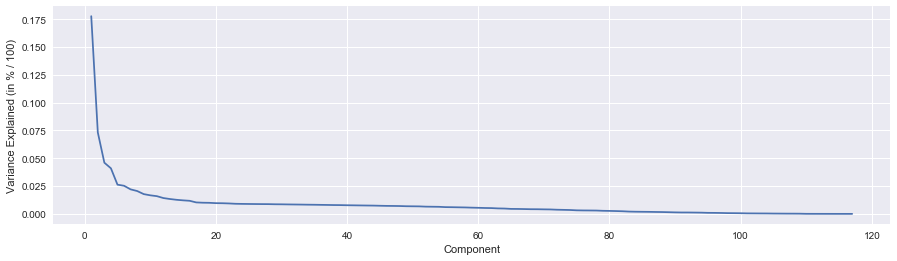

In [17]:
plt.rcParams['figure.figsize'] = (15, 4)

pca_model = PCA()
snsd_PCA = pca_model.fit_transform(scaled_imputed_df)

def sum_variance_explained(pca_model, pca_component_limit, verbose=True):
    '''Finds the total variance explained within n number of components
       variables:
       pca_model           - The model that will be used for calculating variance
       pca_component_limit - How many components will be used to find the sum of variances
       verbose             - Allows verbose output explaining the sum of variances found
       
       returns:
       sum_of_components   - The sum of variances explained up to component n
    '''
    sum_of_components = 0
    for i in range(pca_component_limit):
        sum_of_components += pca_model.explained_variance_ratio_[i]
    if verbose == True:
        print("The first ", pca_component_limit, " components explain ", 
              round(sum_of_components*100, 3), "% of the variance in this data.", sep = "")
    return sum_of_components
    
def find_optimal_components(pca_model, tolerance):
    '''Finds the number of componenets needed to provide enough variance within the tolerance amount
       variables:
       pca_model - The PCA model used for calculations
       tolerance - The minimum amount of variance that must be explained
       
       returns:
       sum_of_components - The sum of variances explained as a percentage
       limit             - How many components were used
    '''
    limit = 0
    sum_of_components = sum_variance_explained(pca_model, 0, verbose=False)
    while (1.00-sum_of_components > tolerance):
        sum_of_components = sum_variance_explained(pca_model, limit, verbose=False)
        limit += 1
    return sum_of_components, limit

# END OF FUNCTION DEFINITIONS
# BEGINNING OF EXAMPLES AND PRINTS

# Examples of the functions defined above
sum_variance_explained(pca_model, 20)
optimal_components = find_optimal_components(pca_model, .10)

print("We must use at least ", optimal_components[1], " components to get ", 
      round(optimal_components[0],2)*100, "% of the variance.", sep="")

num_components_needed = find_optimal_components(pca_model, .10)[1]
    
# Plotting the explained variance for each principle component
list_of_PCA_variances = []
for i in range(len(pca_model.explained_variance_ratio_)):
    list_of_PCA_variances.append(pca_model.explained_variance_ratio_[i])
    
print("\nThese are the principle components that explain more tha 1% of variance")
components_to_use = []
for variance in list_of_PCA_variances:
    if variance > 0.01:
        components_to_use.append(variance)
print(components_to_use)

# This shows an extreme drop off for variances, which infers that we do not need a majority of these columns
# for clustering
plt.plot(np.linspace(1, len(pca_model.explained_variance_ratio_), 
                     len(scaled_imputed_df.columns)), list_of_PCA_variances)
plt.xlabel("Component")
plt.ylabel("Variance Explained (in % / 100)")
plt.show()

This shows that can safely reduce the dimensionlity to 63, while perserving most of the variance. Unfortunately it is still quite high, and will be difficult to visualize as we will be losing a lot of variance by reducing to two or three dimensions.

Let us have a look at the data in two dimensions to see if we can spot anything interesting.

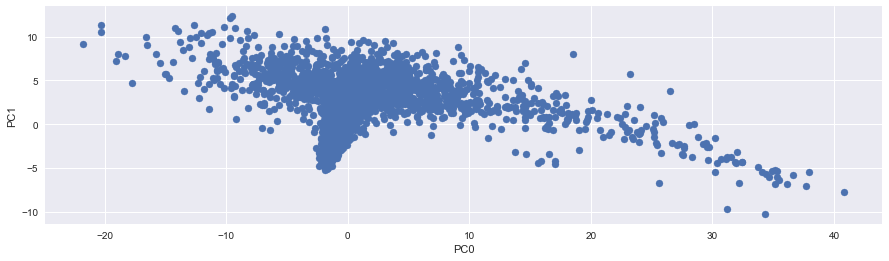

In [18]:
# Take the first two columns to plot
plt.scatter(snsd_PCA[:,0],snsd_PCA[:,1])
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# Build a new dataframe with the PCA values
column_names = []
for i in range(num_components_needed):
    header = "PC"
    component_number = str(i)
    column_names.append(header + component_number)

PCA_DF = pd.DataFrame(snsd_PCA[:,0:len(column_names)], columns=column_names, 
                      index=list(school_data.iloc[:,0]))

We see maybe two groups. One along the veritcal axis and one along the horizontal axis. Even with scaling these values have a very large spread. This indicates that thereis a high amount of variance in this data. What can see with known clustering methods?

Here we test various clustering methods to compare with each other to see if there is an overall group in this data set.

### Running the Spectral Clustering Method:
With our first test, we try out an experimental method that was not discussed heavily. This clustering method uses a graph based approach, and may not be suitable for the data, but we can test it regardless.

In [19]:
# Example spectral clustering models, variables can be changed.
start = time.time()
clustering = SpectralClustering(n_clusters=5, assign_labels="discretize", random_state=0).fit(PCA_DF.iloc[0:500,:])
print("Clusters:", set(clustering.labels_))
end = time.time()
print("\nTime taken: ", end="")
print(end - start)

/home/owen/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/owen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:1105: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(concatenate(arr_rows, axis=0))


Clusters: {0, 1, 2, 3, 4}

Time taken: 16.466489553451538


Unfortunately, this is not a very good method for clustering this data. It is not only two slow, but most likely not going to cluster useful things. We decided to abandon any further testing with this method due to its computational costs. Let us move onto method two.

### Testing KMeans:
How can we do with KMeans? well first test for the optimal value of $k$ by finding where the intra-cluster distance falls off. We do this by testing different values of $k$ and looking at the intra-cluster distance.

In [20]:
plt.rcParams['figure.figsize'] = (10, 4)

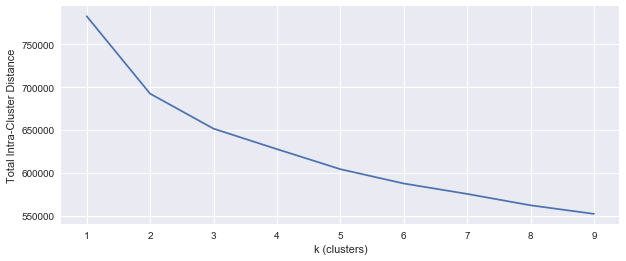

In [21]:
# Testing different clusters
ks = range(1,10)
scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(snsd_PCA)
    scores.append(-model.score(snsd_PCA))

# Plotting the intra-cluster distance
plt.plot(ks, scores)
plt.ylabel('Total Intra-Cluster Distance')
plt.xlabel('k (clusters)')
plt.show()

Unfortunately, we do not see an "elbow" here, but rather a smooth curve that never really drops off. This indicates that our data may not be isotropic and we can not safely divide each cluster using hyperplanes. Because of this, we'll look towards anisotropic clustering methods.

### Testing DBSCAN:
The first method we will test is DBSCAN. If our data is dense, but anisotropic we may be able to find useful clusters with this method. We will test how many clusters we get with different min_samples and eps. 

In [22]:
def test_dbscan(eps, min_samples):
    db_model = DBSCAN(eps=eps, min_samples=min_samples)
    db_model.fit(snsd_PCA)
    y_pred = db_model.fit_predict(snsd_PCA)
    labels = db_model.labels_
    return labels

eps = np.linspace(1,10, 19)
min_samples_n = 10
for i in eps:
    current_set = set(test_dbscan(i, min_samples_n))
    print("With eps = ", i, " and min_samples = ", min_samples_n,", C = ", 
          len(current_set), ". The clusters are: ", current_set, sep="")
    # If we are only getting 1 big cluster, quit checking
    if i > 100 and len(current_set) == 1:
        break

With eps = 1.0 and min_samples = 10, C = 9. The clusters are: {0, 1, 2, 3, 4, 5, 6, 7, -1}
With eps = 1.5 and min_samples = 10, C = 5. The clusters are: {0, 1, 2, 3, -1}
With eps = 2.0 and min_samples = 10, C = 3. The clusters are: {0, 1, -1}
With eps = 2.5 and min_samples = 10, C = 8. The clusters are: {0, 1, 2, 3, 4, 5, 6, -1}
With eps = 3.0 and min_samples = 10, C = 11. The clusters are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
With eps = 3.5 and min_samples = 10, C = 8. The clusters are: {0, 1, 2, 3, 4, 5, 6, -1}
With eps = 4.0 and min_samples = 10, C = 5. The clusters are: {0, 1, 2, 3, -1}
With eps = 4.5 and min_samples = 10, C = 8. The clusters are: {0, 1, 2, 3, 4, 5, 6, -1}
With eps = 5.0 and min_samples = 10, C = 11. The clusters are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1}
With eps = 5.5 and min_samples = 10, C = 14. The clusters are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
With eps = 6.0 and min_samples = 10, C = 12. The clusters are: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1}
With e

We tested DBSCAN with min_samples from 10 to 30 (in steps of 5), and eps from 1 to 10 (in steps of .5). Unfortunately, we this method we found nothing useful. This is not the say we did not find interesting clusters however. For example, with eps = 5.5 we found clusters that included:

0. Unsure
1. Technical schools
2. Truck driving, and vocational schools
3. Cosmetology schools
4. Schools based in California
5. Schools belonging to the Argosy family (Argosy being the orginaization of the schools.)
6. Jewish schools
7. Schools based in Indiana
8. Unsure
9. Beauty School
10. University of Phoenix
11. Nursing schools
12. Golfing schools (surprising!)
13. Recording and productions schools

While these are all very interesting in their own right, for the purposes of exploring tution, they are largely irrelevant. The price of beauty school compared to a golfing school was not something we wanted to analyze. We realized that to explore these clusters in any kind of depth, we needed a much much better background with school data, as combing through the 100+ features for each school was impossible for us to understand. After failing with DBSCAN we wanted to try another method. 



### Testing with HDBSCAN:
HDBSCAN is an extension of DBSCAN which converts it into a hierarchical clustering method. One advantage of this method is that is may help us find more meaningful clusters, and parameters. 

In [23]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
cluster_labels = clusterer.fit_predict(snsd_PCA)
hdlabels = clusterer.labels_
print("Using paramters 1, we found ", len(set(hdlabels)), " giving us the clusters: ", set(hdlabels), sep="")

clusterer2 = hdbscan.HDBSCAN(min_cluster_size=25)
cluster_labels2 = clusterer2.fit_predict(snsd_PCA)
hdlabels2 = clusterer2.labels_
print("Using paramters 2, we found ", len(set(hdlabels2)), " giving us the clusters: ", set(hdlabels2), sep="")

clusterer3 = hdbscan.HDBSCAN(min_cluster_size=15)
cluster_labels3 = clusterer3.fit_predict(snsd_PCA)
hdlabels3 = clusterer3.labels_
print("Using paramters 3, we found ", len(set(hdlabels3)), " giving us the clusters: ", set(hdlabels3), sep="")

Using paramters 1, we found 3 giving us the clusters: {0, 1, -1}
Using paramters 2, we found 5 giving us the clusters: {0, 1, 2, 3, -1}
Using paramters 3, we found 17 giving us the clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, -1}


We can also view the condensed tree to see where the clusters were chosen from.

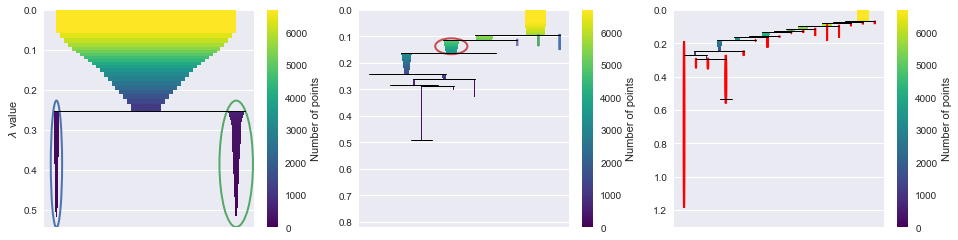

In [24]:
plt.rcParams['figure.figsize'] = (16, 4)
fig, ax = plt.subplots(1, 3)     

plt.sca(ax[0])
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette());

plt.sca(ax[1])                
clusterer2.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette());
ax[1].set_ylabel("")

plt.sca(ax[2])                
clusterer3.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette());
ax[2].set_ylabel("");

Here we can see a little bit more of how the clustering is being broken down. It seems we are met with two options. We either have a dichotomous division, where we have two relatively large clusters, or we get one massive cluster, and several little irrelevant ones.

In [25]:
# Here we assign each item with it's cluster label
clusterList = list(zip(hdlabels, snsd_PCA))

# We then remove any item associated with -1 (removing noise)
for i in sorted(clusterList, key=lambda x: x[0]):
    if i[0] < 0:
        clusterList.remove(i)

# We then sort in ascending order
sorted_ClusterList = sorted(clusterList, key=lambda x: x[0])

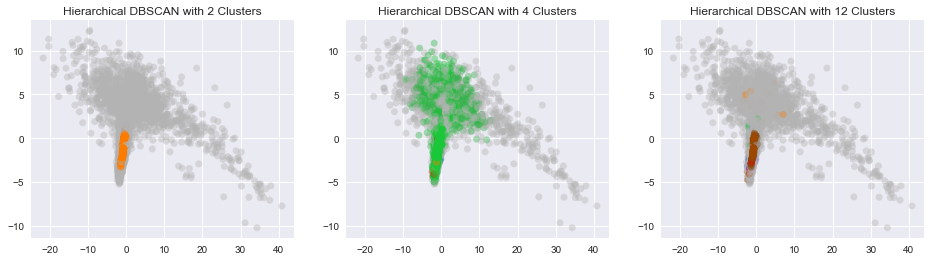

In [26]:
# Coloring clusters for HDBSCAN 1
color_palette = sns.color_palette('bright', 100)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.7, 0.7, 0.7)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

# Coloring clusters for HDBSCAN 2
color_palette2 = sns.color_palette('bright', 100)
cluster_colors2 = [color_palette2[x] if x >= 0
                  else (0.7, 0.7, 0.7)
                  for x in clusterer2.labels_]
cluster_member_colors2 = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors2, clusterer2.probabilities_)]

# Coloring clusters for HDBSCAN 3
color_palette3 = sns.color_palette('bright', 100)
cluster_colors3 = [color_palette3[x] if x >= 0
                  else (0.7, 0.7, 0.7)
                  for x in clusterer3.labels_]
cluster_member_colors3 = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors3, clusterer3.probabilities_)]


# Setting up plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 4)
fig, ax = plt.subplots(1, 3) 

plt.sca(ax[0])
plt.scatter(snsd_PCA[:,0], snsd_PCA[:,1],  linewidth=0, c=cluster_member_colors, alpha=0.4);
plt.title("Hierarchical DBSCAN with 2 Clusters");

plt.sca(ax[1])                
plt.scatter(snsd_PCA[:,0], snsd_PCA[:,1],  linewidth=0, c=cluster_member_colors2, alpha=0.4);
plt.title("Hierarchical DBSCAN with 4 Clusters");

plt.sca(ax[2])                
plt.scatter(snsd_PCA[:,0], snsd_PCA[:,1],  linewidth=0, c=cluster_member_colors3, alpha=0.4);
plt.title("Hierarchical DBSCAN with 12 Clusters");

With 2, and 18 clusters we do not see much of anything interesting going on. These schools are again very unrelated and do not give us anything interesting to analyze. However, if we look at the group with 4 clusters we see something very interesting. For any of the PCA values where $x > 10$ and $x < -10$ We can see maybe 3 main clusters. According to our condensed tree, these cluster do not have many schools in them, but they are still worth examining.

In particular, we will look at this segment here:

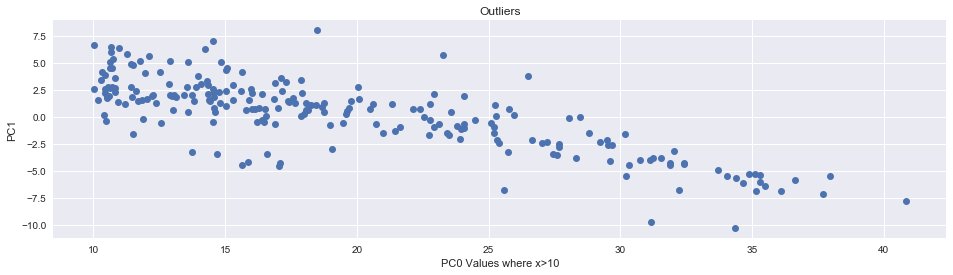

In [27]:
plt.scatter(PCA_DF['PC0'][PCA_DF['PC0'] > 10], PCA_DF['PC1'][PCA_DF['PC0'] > 10],  linewidth=0);
plt.title("Outliers");
plt.xlabel("PC0 Values where x>10")
plt.ylabel("PC1");

Now where do these schools exist in our data?

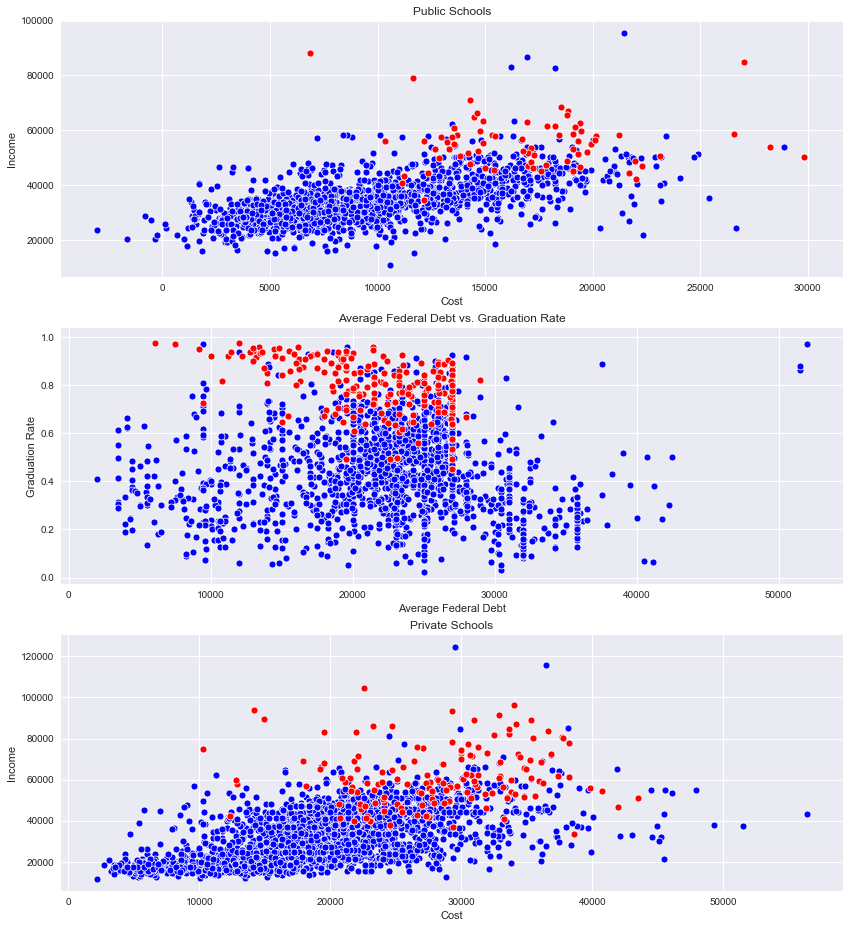

In [28]:
# Setting index back to numeric values
PCA_DF = pd.DataFrame(snsd_PCA[:,0:len(column_names)], columns=column_names)

plt.rcParams['figure.figsize'] = (14, 16)
fig, ax = plt.subplots(3, 1)  

x_outliers = PCA_DF['PC0'][PCA_DF['PC0'] > 10].index
school_data.iloc[x_outliers, : ]
sns.scatterplot(x="NPT4_PUB", y="MD_EARN_WNE_P10", data=school_data_original, ci=None, color='blue', ax=ax[0])
sns.scatterplot(x="NPT4_PUB", y="MD_EARN_WNE_P10", data=school_data_original.iloc[x_outliers, : ], ci=None, color='red', ax=ax[0])
ax[0].set_title("Public Schools")
ax[0].set_xlabel('Cost')
ax[0].set_ylabel('Income')

sns.scatterplot(x="GRAD_DEBT_MDN_SUPP", y="C150_4_POOLED_SUPP", data=school_data_original, ci=None, color='blue', ax=ax[1])
sns.scatterplot(x="GRAD_DEBT_MDN_SUPP", y="C150_4_POOLED_SUPP", data=school_data_original.iloc[x_outliers, : ], ci=None, color='red', ax=ax[1])
ax[1].set_title("Average Federal Debt vs. Graduation Rate")
ax[1].set_xlabel('Average Federal Debt')
ax[1].set_ylabel('Graduation Rate');


sns.scatterplot(x="NPT4_PRIV", y="MD_EARN_WNE_P10", data=school_data_original, ci=None, color='blue', ax=ax[2])
sns.scatterplot(x="NPT4_PRIV", y="MD_EARN_WNE_P10", data=school_data_original.iloc[x_outliers, : ], ci=None, color='red', ax=ax[2])
ax[2].set_title("Private Schools")
ax[2].set_xlabel('Cost')
ax[2].set_ylabel('Income');

Interestingly enough, it seems that these outliers were the schools we were looking for. Let us examine these schools to see which schools are apart of this compliment cluster.

In [29]:
school_data.iloc[x_outliers, : ][['NPT4_PUB', 'NPT4_PRIV', 'MD_EARN_WNE_P10']].head(15)

,NPT4_PUB,NPT4_PRIV,MD_EARN_WNE_P10
3,19423.0,NaN,46700.0
5,21676.0,NaN,44500.0
9,21984.0,NaN,48800.0
152,NaN,21779.0,39700.0
216,NaN,24702.0,85900.0
218,18845.0,NaN,66900.0
233,14468.0,NaN,64700.0
234,15309.0,NaN,58200.0
235,13712.0,NaN,58400.0
236,13572.0,NaN,60700.0


We may have found the cluster we were initially hoping for! Most of the schools in this "compliment" cluster are all well respected schools (this can be further verified by looking more into this dataframe, the results have been omitted for space)

Let us see how these special schools compare to the rest of the schools. 

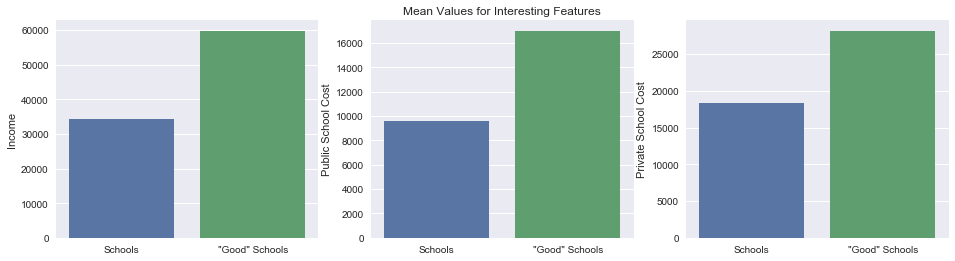

In [30]:
plt.rcParams['figure.figsize'] = (16, 4)
fig, ax = plt.subplots(1, 3)     
    
# Removing the outliers from the main data frame, so we can compare them separately
schools_set_a = pd.concat([school_data, school_data.iloc[x_outliers, : ], school_data.iloc[x_outliers, : ]]).drop_duplicates(keep=False)
schools_set_a_compliment = school_data.iloc[x_outliers, : ]

plt.sca(ax[0])
y1 = schools_set_a['MD_EARN_WNE_P10'].mean()
y2 = schools_set_a_compliment['MD_EARN_WNE_P10'].mean()

sns.barplot(x=["Schools", "\"Good\" Schools"], y=[y1, y2])
ax[0].set_ylabel("Income")

plt.sca(ax[1])
y1 = schools_set_a['NPT4_PUB'].mean()
y2 = schools_set_a_compliment['NPT4_PUB'].mean()

sns.barplot(x=["Schools", "\"Good\" Schools"], y=[y1, y2])
ax[1].set_ylabel("Public School Cost")
ax[1].set_title("Mean Values for Interesting Features")

plt.sca(ax[2])
y1 = schools_set_a['NPT4_PRIV'].mean()
y2 = schools_set_a_compliment['NPT4_PRIV'].mean()

sns.barplot(x=["Schools", "\"Good\" Schools"], y=[y1, y2])
ax[2].set_ylabel("Private School Cost");


These schools offer high income, and only a marginal increase in cost. We now have a model that may be able to predict if a school is in this special compliment cluster, by simply checking if the imputed scaled PCA gives us a PC0 where $x>10$. 

To summarize, we used the clustering methods in hopes of finding a cluster that gave us good schools to analyse, however most of the methods did not help us find what we were looking for. By looking at the outliers in the PCA, we found that the cluster with -1 was actually the most likely to contain these good schools. 